In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')

In [3]:
df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20
0,Anhui,Mainland China,31.82570,117.2264,1,9,15,39,60,70,...,988,989,989,989,989,989,989,990,990,990
1,Beijing,Mainland China,40.18240,116.4142,14,22,36,41,68,80,...,396,399,399,399,400,400,410,410,411,413
2,Chongqing,Mainland China,30.05720,107.8740,6,9,27,57,75,110,...,572,573,575,576,576,576,576,576,576,576
3,Fujian,Mainland China,26.07890,117.9874,1,5,10,18,35,59,...,293,293,293,293,294,294,296,296,296,296
4,Gansu,Mainland China,36.06110,103.8343,0,2,2,4,7,14,...,91,91,91,91,91,91,91,91,91,91
5,Guangdong,Mainland China,23.34170,113.4244,26,32,53,78,111,151,...,1333,1339,1342,1345,1347,1347,1347,1348,1349,1349
6,Guangxi,Mainland China,23.82980,108.7881,2,5,23,23,36,46,...,246,249,249,251,252,252,252,252,252,252
7,Guizhou,Mainland China,26.81540,106.8748,1,3,3,4,5,7,...,146,146,146,146,146,146,146,146,146,146
8,Hainan,Mainland China,19.19590,109.7453,4,5,8,19,22,33,...,168,168,168,168,168,168,168,168,168,168
9,Hebei,Mainland China,38.04280,114.5149,1,1,2,8,13,18,...,308,309,311,311,311,312,317,318,318,318


In [4]:
def exp(x, a, b, c):
    return a * np.exp(b * x) + c

In [5]:
summary = df.iloc[:,[1,-1]].groupby('Country/Region').sum()
mostrecentdate = summary.columns[0]
summary = summary.sort_values(by = mostrecentdate, ascending = False)
summary[0:20]

,3/1/20
Country/Region,
Mainland China,79826
South Korea,3736
Italy,1694
Iran,978
Others,705
Japan,256
Germany,130
France,130
Singapore,106


In [76]:
def plotCases(country):
    co = df[df['Country/Region'] == country].iloc[:,4:].T.sum(axis = 1)
    co = pd.DataFrame(co)
    co.columns = ['Cases']
    co = co.loc[co['Cases'] > 0]

    y = np.array(co['Cases'])
    x = np.arange(y.size)

    try:
        popt, pcov = curve_fit(exp, x, y)

        residuals = y - exp(x, *popt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        r_squared = 1 - (ss_res / ss_tot)    

        if r_squared >= 0.95:
            
            plt.figure()
            plt.plot(x, y, 'ko', label="Original Data")
            plt.plot(x, exp(x, *popt), 'r-', label="Fitted Curve")
            plt.legend(title = country + ' COVID-19 Cases')
            plt.show()

            print('exponential fit: ', popt[0], 'exp(', popt[1], ' x) +', popt[2])
            print('R squared:', round(r_squared,2))
            print('Doubling time: ', round((1/popt[1])/np.log2(np.e),2), 'days')

            return (1/popt[1])/np.log2(np.e)
        
        else:
            plt.figure()
            plt.plot(x, y, 'ko', label="Original Data")
            plt.legend(title = country + ' COVID-19 Cases')
            plt.show()
            

    except:
        plt.figure()
        plt.plot(x, y, 'ko', label="Original Data")
        plt.legend(title = country + ' COVID-19 Cases')
        plt.show()
        


Mainland China


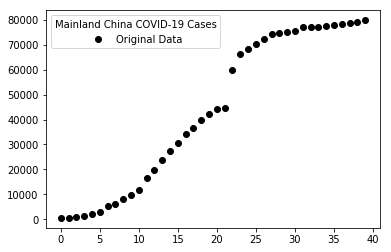



South Korea


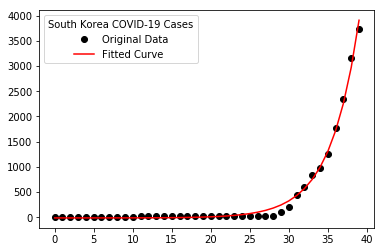

exponential fit:  0.0948624729795 exp( 0.272547146175  x) + -13.3539549034
R squared: 0.99
Doubling time:  2.54 days


Italy


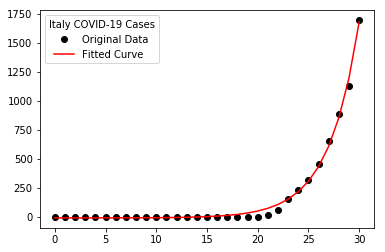

exponential fit:  0.0732222023583 exp( 0.334830046185  x) + -8.59056070883
R squared: 1.0
Doubling time:  2.07 days


Iran


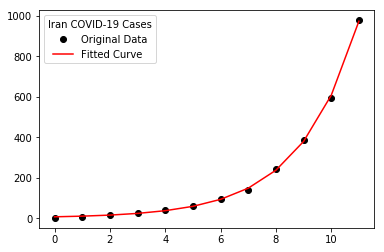

exponential fit:  5.37005528613 exp( 0.472499824188  x) + 2.1038922084
R squared: 1.0
Doubling time:  1.47 days


Others


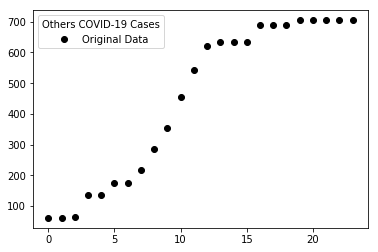



Japan


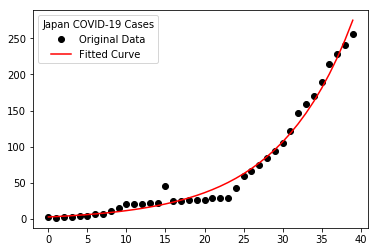

exponential fit:  4.79358392805 exp( 0.104082981725  x) + -2.43865729275
R squared: 0.99
Doubling time:  6.66 days


Germany


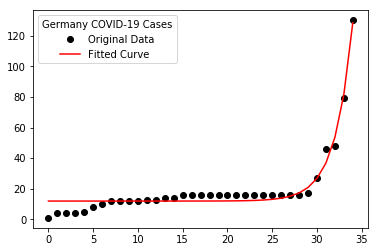

exponential fit:  2.88509391338e-06 exp( 0.515064301412  x) + 12.001876823
R squared: 0.96
Doubling time:  1.35 days


France


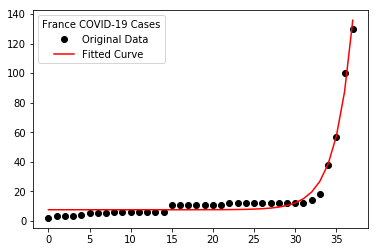

exponential fit:  3.10344370934e-06 exp( 0.473974588844  x) + 7.53202360311
R squared: 0.97
Doubling time:  1.46 days


Singapore


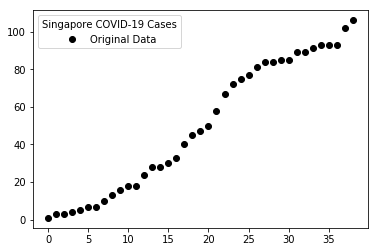



Hong Kong


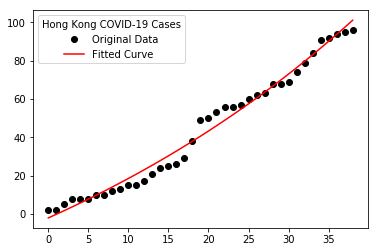

exponential fit:  102.109436086 exp( 0.0183866354604  x) + -104.233544102
R squared: 0.98
Doubling time:  37.7 days


Spain


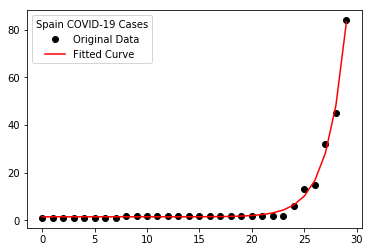

exponential fit:  7.63897979513e-06 exp( 0.558131719881  x) + 1.46297326058
R squared: 0.99
Doubling time:  1.24 days


US


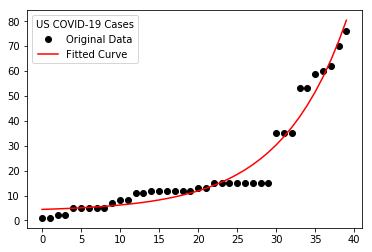

exponential fit:  0.787634759552 exp( 0.117425866205  x) + 3.63399600323
R squared: 0.95
Doubling time:  5.9 days


Bahrain


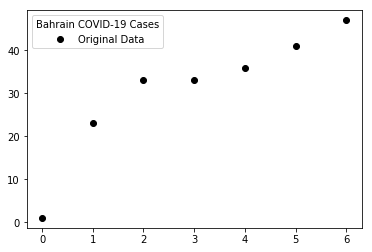



Kuwait


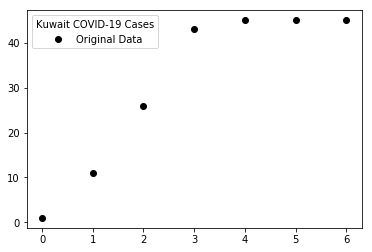



Thailand


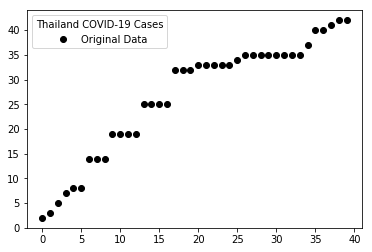



Taiwan


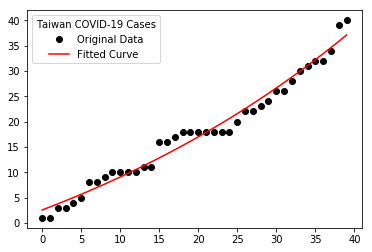

exponential fit:  29.9505562443 exp( 0.0196577308385  x) + -27.3822173551
R squared: 0.98
Doubling time:  35.26 days


UK


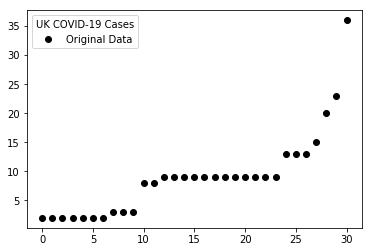



Malaysia


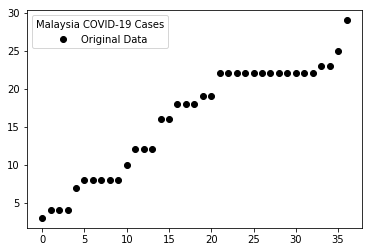



Switzerland


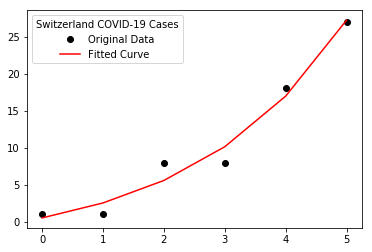

exponential fit:  4.03878809595 exp( 0.405696923449  x) + -3.5001172521
R squared: 0.97
Doubling time:  1.71 days


Australia


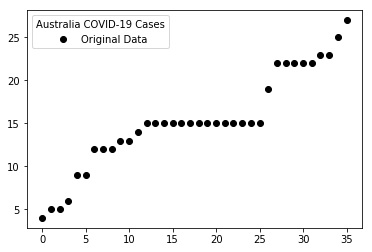

In [77]:
topcountries = summary.index[0:20]
doublingtime = []
countries = []
print();

for c in topcountries:
    print(c)
    a = plotCases(c)
    if a:
        countries.append(c)
        doublingtime.append(a)
    print('\n')

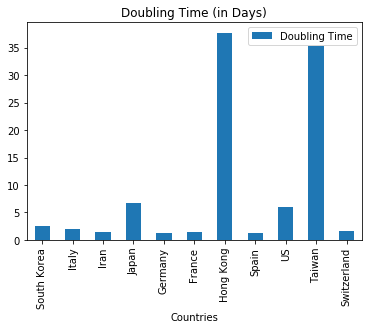

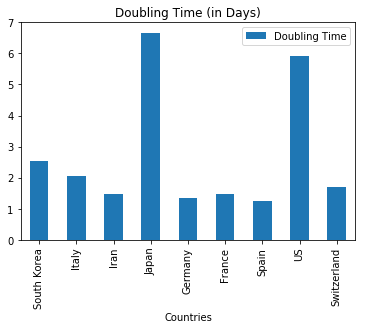

In [96]:
d = {'Countries': countries, 'Doubling Time': doublingtime}

dt = pd.DataFrame(data = d)
dt.plot.bar(x = 'Countries', y = 'Doubling Time', title = 'Doubling Time (in Days)');

dtf = dt[dt['Doubling Time'] < 30]
dtf.plot.bar(x = 'Countries', y = 'Doubling Time', title = 'Doubling Time (in Days)');

plt.show()